Exploring the $\chi^2$ distribution
===

Start with some model to generate random data.  <br> 
We'll use $0.2+\frac{sin(x)}{x+1}$ over the range $0\leq x<15$ <br>
Generate $N$ random numbers according to this distribution and make a histogram of the results using 30 bins. 

An easy way to generate random numbers according to an arbitrary distribution is to use rejection sampling (here's a great [decription  of the technique](https://matthewfeickert.github.io/Statistics-Notes/notebooks/simulation/Rejection-Sampling-MC.html) )

1) Make a histogram of your random distribution.  Verify that the the numbers you generated agree with the shape of the function.  Generate at least 10000 points and plot your data in a histogram with errorbars.  You can use numpy+matplotlib+etc, PyROOT, or a mix.  Think about how to appropriately normalize your function, then overlay it with the data.  The normalization depends on the number of bins, the bin range and the number of points thrown.  You may find it easier to first nromalize the area of your function to 1.0, thus turning it into a proper PDF.  

In [12]:
# your work goes here

# First, set constant parameters
n_points = 10*1000 # points to draw
n_bins = 30 # NOTE THAT THIS CHANGES LATER ON TO A LIST!
x_minimum = 0
x_maximum = 15
n_parameters = 4

# for histograms and plotting
import ROOT as R

# original function, not normalized to a proper PDF
tfDistribution = R.TF1("tfDistribution", "0.2 + sin(x) / (x + 1)", x_minimum, x_maximum, 0)
area_under_curve = tfDistribution.Integral(x_minimum, x_maximum) # normalization coefficient

# normalized PDF
tfDist = R.TF1("tfDist", "(1./[0]) * (0.2 + sin(x) / (x + 1))", x_minimum, x_maximum, 1) # remember 1/3 = 0, so need 1./3.
tfDist.SetParameter(0, area_under_curve) # set the zero-th parameter as the normalization coefficient
tfDist.Update()

In [13]:
# Next, take random data samples from the distribution and draw the associated histogram.
h1 = R.TH1F("h1", "10,000 random data points from function", n_bins, x_minimum, x_maximum)
h1.FillRandom("tfDist", n_points)

# canvas object to store plots
tc1 = R.TCanvas()

h1.Draw() # draw regular histogram
h1.Draw("same, e") # overlay existing plot with errorbars
tc1.Draw() # display the canvas

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


In [14]:
# Make a new canvas to overlay the distribution and the histogram together
tc2 = R.TCanvas()

# to plot distribution, need to scale with histogram
tfDist_plotting = R.TF1("tfDist_plotting", "([1]/[0])*([2]/[3])*(0.2 + sin(x) / (x + 1))", x_minimum, x_maximum, n_parameters)
tfDist_plotting.SetParameter(0, area_under_curve)
tfDist_plotting.SetParameter(1, float(n_points))
tfDist_plotting.SetParameter(2, float(x_maximum-x_minimum))
tfDist_plotting.SetParameter(3, n_bins)
tfDist_plotting.Update()
h1.Draw()
h1.Draw('same, e')
tfDist_plotting.Draw("same") # overlay distribution on histogram
tc2.Draw()

2) Repeat the above experiment at least 1000 times.  For each experiment calculate the $\chi^2$ of your data with respect to your (properly normalized) model.  Plot (histogram) the $\chi^2$ distribution and compare it to the functional form of the $\chi^2(ndof=30)$ distribution.  You can find the form of the $\chi^2(ndof)$ PDF function in many places and implement it using the Gamma function or use a premade function, eg:
* [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution)
* [scipy.stats.chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2)

In [15]:
# your work goes here

We have to calculate chi-square for each point in each trial. The chi-square we are calculating is with respect to the entries in each bin. We already have error bars from the histograms above, so we can use those as our sigmas in the chi-square formula. Now, we just need to get the "ideal histogram" that has our expectation values for each bin. Retrieving the content and error from the bins is relatively straight-forward. We must call the methods GetBinContent() and GetBinError() on the histogram. Loop to get the content and errors of each bin. We should make this into a function and call it!

In [16]:
def calculate_bin_information(histogram):
    """
    Returns the number of bins and center, content, and error for each bin in a pyROOT histogram object.
    Skips the 0th and final bins, since they're for under- and over-flow only.
    Parameter: TH1F Histogram object
    Returns:
    data : a list containing the following in order
        count : int, number of bins in histogram
        centers : float list length of count, location of centers for each bin
        contents : float list length of count, has number in bin
        errors : float list length of count, has error for each bin
    """
    centers = []
    contents = []
    errors = []
    for i in range(1, histogram.GetNbinsX() + 1): # pyROOT histogram object method names are self-explanatory
        centers.append(histogram.GetBinCenter(i)) # location of center
        contents.append(histogram.GetBinContent(i)) # value of bin
        errors.append(histogram.GetBinError(i)) # value of bin errorbar
    count = i
    data = [count, centers, contents, errors]

    return data

Now that we have the bin centers, we should get the "ideal histogram" by taking the centers and plugging that in to the stretched distribution that fits the histogram from earlier.

In [17]:
def calculate_chi_square(data, distribution):
    """
    given the data from calculate_bin_information() and its parent distribution,
    returns the chi-square of that particular interaction.

    Requires the distribution to be properly normalized to the histogram.
    """
    total_chi_square = 0. # accumulator
    for i in range(data[0]): # data[0] is the number of bins
        center = data[1][i] # data[1] is the centers
        measured_value = data[2][i] # data[2] is the contents
        expected_value = distribution(center)
        residual = measured_value - expected_value
        sigma = data[3][i] # data[3] is the errors
        partial_chi = residual / sigma
        partial_chi_square = partial_chi * partial_chi
        total_chi_square += partial_chi_square # add to accumulator

    return total_chi_square

In [18]:
# To get chi-square data, we'll just loop over new histograms

# set parameters
n_trials = 1000

list_of_chi = [] # accumulator
for i in range(n_trials):
    h1.SetDirectory(R.nullptr)
    del h1 # primarily just to get rid of that annoying memory message
    h1 = R.TH1F("h1", "10,000 random data points from function", n_bins, x_minimum, x_maximum)
    h1.FillRandom("tfDist", n_points) # refill a new histogram
    chi_square = calculate_chi_square(calculate_bin_information(h1), tfDist_plotting)
    list_of_chi.append(chi_square) # accumulate values

In [19]:
# Now that we have the chi-square data, let's put it into a histogram!
h2 = R.TH1F("h2", "1,000 chi-squares from earlier data", n_bins, 0, 60)
for chi in list_of_chi:
    h2.Fill(chi) # can only fill one at a time from a python list. solution is loop

# now for plotting, we also want the functional form of the chi-square distribution
tc4 = R.TCanvas()
h2.Draw() # chi-square histogram
h2.Draw('same, e')
from scipy.stats import chi2 # get functional form of chi-square distribution
import numpy as np
x = np.linspace(0, 60, n_points) # get 1000 x_values
y = chi2.pdf(x, 30) # first parameter is x-vals, second parameter is "degrees of freedom"~order of chi-square distribution

# need the bin widths for scaling.
histogram_data = calculate_bin_information(h2)
bin_width = histogram_data[1][2] - histogram_data[1][1] # difference between adjacent bins is width

for i, element in enumerate(y):
    y[i] *= n_trials * bin_width # correct scaling factor
chi_distribution = R.TGraph(n_points, x, y)
chi_distribution.Draw('same')
tc4.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).


**Only required for Phys5630**

3) Modify your code above to perform the following study. <br>
Repeat (2) for nbins = $ndof = 30, 50, 75, 100$ and calculate the reduced $\chi^2$, eg $\chi^2/ndof$ for each experiment.  Plot the mean value of the reduced $\chi^2$ with errorbars versus $ndof$.  Make a table comparing your calculations to the expected results.

In [20]:
# your work goes here

Let's just redo the calculations above for multiple numbers of bins. I want to make a short function that calculates the array of chi-square information, just like last time. Then, I can just make a histogram for each of those!

In [21]:
def accumulate_chi_values(n_bins):
    list_of_reduced_chi = []
    for i in range(n_trials):
        # h1.SetDirectory(R.nullptr)
        # del h1
        h1 = R.TH1F("h1", "10,000 random data points from function", n_bins, x_minimum, x_maximum)
        h1.FillRandom("tfDist", n_points)
        chi_square = calculate_chi_square(calculate_bin_information(h1), tfDist_plotting)
        list_of_reduced_chi.append(chi_square / n_bins)
    
    return list_of_reduced_chi

In [22]:
# set parameters
# NOTE NOW n_bins IS A LIST!!!
n_bins = [30, 50, 75, 100]
bins = n_bins[3]

# reset plotting distribution for each plot.
tfDist_plotting.SetParameter(3, bins)
tfDist_plotting.Update()
list_of_chi = accumulate_chi_values(bins)
# the first time I run this block on a fresh kernel, it gives me a division by zero error for the above line, but I don't really want to go figure it out.
# so if you have that problem, just run it again and it goes away.

# fill and plot
h3 = R.TH1F("h2", "1,000 chi-squares from earlier data", 30, 0, 2)
for chi in list_of_chi:
    h3.Fill(chi)

tc5 = R.TCanvas()
h3.Draw()
tc5.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing ex

In [23]:
# So, the code works. Let's make sure we can plot all 4 of the desired histograms on the same canvas.

# new canvas, but 4 subplots now in a 2x2.
tc6 = R.TCanvas()
tc6.Divide(2, 2)

hist1 = R.TH1F("hist1", "30 bins", 30, 0, 2)
hist2 = R.TH1F("hist2", "50 bins", 30, 0, 2)
hist3 = R.TH1F("hist3", "75 bins", 30, 0, 2)
hist4 = R.TH1F("hist4", "100 bins", 30, 0, 2)

histograms = [hist1, hist2, hist3, hist4] # to be looped over

# accumulators
means = []
stdevs = []

# now loop over it all
for i, bins in enumerate(n_bins):
    tfDist_plotting.SetParameter(3, bins)
    tfDist_plotting.Update()
    list_of_chi = accumulate_chi_values(bins)
    for chi in list_of_chi:
        histograms[i].Fill(chi)
    means.append(histograms[i].GetMean())
    stdevs.append(histograms[i].GetStdDev())

# now draw and show plots
# NOTE for some weird reason, pyroot indexes at 1 here, whereas python is normally at 0.
tc6.cd(1)
hist1.Draw()
tc6.cd(2)
hist2.Draw()
tc6.cd(3)
hist3.Draw()
tc6.cd(4)
hist4.Draw()

tc6.Update()
tc6.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing ex

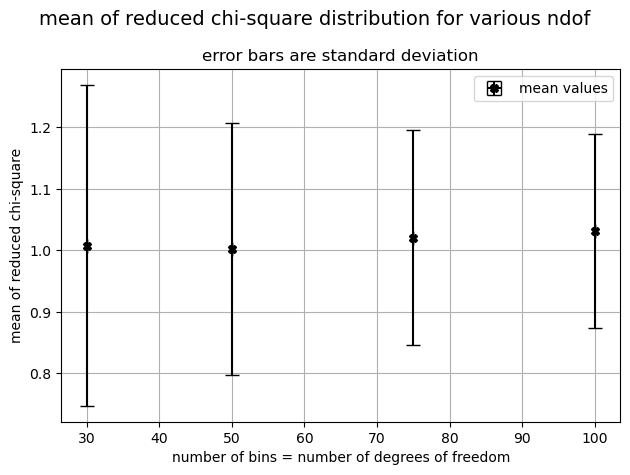

In [24]:
# Looks like we have the desired graphs of reduced chi-square now. Good!

# Just doing matplotlib, since it's easier for me in this context.
import matplotlib.pyplot as plt
fig = plt.figure()
plt.errorbar(n_bins, means, stdevs, 0, linestyle = 'none', marker = 'X', color = 'k', label = 'mean values', capsize=5)
plt.xlabel('number of bins = number of degrees of freedom')
plt.ylabel('mean of reduced chi-square')
plt.suptitle('mean of reduced chi-square distribution for various ndof', fontsize = 14)
plt.title('error bars are standard deviation')
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

In [25]:
# Print the means and stdevs of above
print(means)
print(stdevs)

[1.0077082772289523, 1.0027675869360397, 1.0205698243081691, 1.0308408173554489]
[0.2603595783213037, 0.20473376238182306, 0.17441532611981939, 0.15794269421537763]


Took the means and stdevs of some old runs, since I don't know how to get the markdown cells to update based on the code.

| n_dof | mean ~ measured | standard deviation ~ measured | mean ~ expected | standard deviation ~ expected|
|---|---|---|---|---|
| 30 | 1.0077 | 0.2604 | 1.0000 | sqrt(2/30) = 0.2582 |
| 50 | 1.0028 | 0.2047 | 1.0000 | sqrt(2/50) = 0.2000 |
| 75 | 1.0206 | 0.1744 | 1.0000 | sqrt(2/75) = 0.1633 |
| 100 | 1.0308 | 0.1579 | 1.0000 | sqrt(2/100) = 0.1414 |

Luckily, the measured values are close to the expected values.